In [1]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_community.utilities import SerpAPIWrapper
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI
from langchain.agents import create_tool_calling_agent
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_teddynote.models import MultiModal
from typing import Annotated, TypedDict, Optional, Literal, Tuple, Optional, Dict, Any
import os
import json
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from typing_extensions import Literal

C:\Users\SSAFY\AppData\Local\pypoetry\Cache\virtualenvs\langchain-kr-RWZ68D9H-py3.11\Lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
# api key
from dotenv import load_dotenv

load_dotenv()

Python-dotenv could not parse statement starting at line 7
Python-dotenv could not parse statement starting at line 8
Python-dotenv could not parse statement starting at line 9
Python-dotenv could not parse statement starting at line 10
Python-dotenv could not parse statement starting at line 11
Python-dotenv could not parse statement starting at line 12
Python-dotenv could not parse statement starting at line 13
Python-dotenv could not parse statement starting at line 14
Python-dotenv could not parse statement starting at line 15
Python-dotenv could not parse statement starting at line 16


True

In [3]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("TEST_LangGraph_Chart")

LangSmith 추적을 시작합니다.
[프로젝트명]
TEST_LangGraph_Chart


In [4]:
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time

def capture_chart_screenshot():
    # 크롬 드라이버 설치 후 경로 지정 필요
    chrome_driver_path = "./chromedriver-win64/chromedriver-win64/chromedriver.exe"
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")
    chrome_options.add_argument("--window-size=1920x1080")

    service = Service(chrome_driver_path)
    driver = webdriver.Chrome(service=service, options=chrome_options)

    try:
        print("Starting Chrome Driver")
        url = "https://upbit.com/full_chart?code=CRIX.UPBIT.KRW-BTC"
        driver.get(url)
        print("Page loaded")

        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, "//*[@id='fullChartiq']")))
        print("Element found")

        # 메뉴 버튼 및 "4시간" 차트 클릭
        menu_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, "//*[@id='fullChartiq']/div/div/div[1]/div/div/cq-menu[1]/span/cq-clickable"))
        )
        menu_button.click()
        print("Menu button clicked")

        four_hour_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, "//*[@id='fullChartiq']/div/div/div[1]/div/div/cq-menu[1]/cq-menu-dropdown/cq-item[9]"))
        )
        four_hour_button.click()
        print("4-hour chart selected")

        time.sleep(2)
        current_time = datetime.now().strftime("%m%d_%H")
        # 스크린샷 저장 경로 및 파일 명 설정 필요
        screenshot_path = f"{current_time}_upbit_full_chart_4hour.png"
        driver.save_screenshot(screenshot_path)
        print(f"Screenshot saved at: {screenshot_path}")

        return screenshot_path

    except Exception as e:
        print(f"Error in capture_chart_screenshot: {e}")

    finally:
        driver.quit()
        print("Driver quit")

In [5]:
# State 정의
class State(BaseModel):
    messages: Annotated[list, add_messages]
    fng: Optional[dict] = None
    news_search: Optional[dict] = None
    quant: Optional[dict] = None
    chart: Optional[dict] = None
    master: Optional[dict] = None


llm = ChatOpenAI(model="gpt-4o", temperature=0)


# 공포 탐욕 지수 함수
url = "https://api.alternative.me/fng/?date_format=kr&limit="

def get_fng():
    _url = url + "30"
    res = requests.request("GET", _url)
    parsed = json.loads(res.text)
    data = parsed["data"]
    info = [int(item['value']) for item in data]
    return info

# fng_agent 정의
fng_template = """당신은 투자 분석 전문가 입니다.
    Level 1: 0-25 points — Extreme Fear: Indicates a high level of pessimism; investors are highly risk-averse.
    Level 2: 26-50 points — Fear: Suggests cautious sentiment; investors are generally reluctant to take on risk.
    Level 3: Around 50 points — Neutral: Shows a balanced market sentiment with neither fear nor greed prevailing.
    Level 4: 51-75 points — Greed: Investors are becoming more optimistic, showing a greater willingness to take on risk.
    Level 5: 76-100 points — Extreme Greed: Indicates very high levels of optimism; investors are extremely risk-seeking.

    현재 공포 탐욕 지수의 최근 30일 지수의 정보는 다음과 같습니다:
    {info}

    분석 결과를 다음 JSON 형식으로 제공해주세요:
    {{
        "decision": "BUY 또는 SELL 또는 HOLD 중 하나로만 작성",
        "summary": "시장 분석 및 예측 내용을 상세히 서술. 투자 결정을 제안하고 해당 이유를 서술",
    }}

    주의사항:
    - decision은 반드시 BUY 또는 SELL 또는 HOLD 중 하나여야 합니다
    - summary는 현재 시장 상황과 향후 전망을 포함해야 합니다. 투자 결정을 제안하고 해당 이유를 서술해야 합니다
    """
fng_prompt_template = PromptTemplate.from_template(fng_template)

class FngAnalysis(TypedDict):
    summary: str
    decision: Literal["BUY", "SELL", "HOLD"]

json_output_parser = JsonOutputParser(pydantic_object=FngAnalysis)
fng_chain = fng_prompt_template | llm | json_output_parser

def fng_agent(state: State) -> State:
    # 공포 탐욕 지수 메시지
    fng_info = get_fng()
    result = fng_chain.invoke({"info": fng_info})
    
    # 메시지를 추가
    new_message = f"FNG Analysis Decision: {result['decision']}, Summary: {result['summary']}"
    updated_messages = state.messages + [new_message]
    
    # 상태 업데이트
    return state.copy(update={"messages": updated_messages, "fng": {"decision": result["decision"], "summary": result["summary"]}})



# 뉴스 검색 에이전트
search = SerpAPIWrapper()

news_search_template = """당신은 비트코인 시장의 투자 분석 전문가입니다. 
    최신 뉴스에서 비트코인 관련 시장 동향을 조사하고 이를 분석하여 결정하세요.
    
    다음의 뉴스 기사들을 참조하여 BUY, SELL, HOLD 중 하나의 결정을 내리세요:
    {articles}

    결과는 반드시 JSON 형식으로 출력하세요:
    {{
        "decision": "BUY 또는 SELL 또는 HOLD 중 하나로만 작성",
        "summary": "뉴스 동향에 기반한 시장 분석과 투자 결정을 서술",
        "sources": ["뉴스 기사 링크를 포함해 주세요"]
    }}
    """
news_search_prompt_template = PromptTemplate.from_template(news_search_template)

class NewsSearchAnalysis(BaseModel):
    summary: str
    decision: Literal["BUY", "SELL", "HOLD"]
    sources: list[str]

news_output_parser = JsonOutputParser(pydantic_object=NewsSearchAnalysis)
news_search_chain = news_search_prompt_template | llm | news_output_parser

def news_search_agent(state: State) -> State:
    # 뉴스 메시지
    search_results = search.run("bitcoin latest news")
    articles = "\n".join([f"- {item['title']} ({item['link']})" for item in search_results[:5]])

    # 모델에 기사 제목과 링크 포함해 프롬프트 생성 및 응답 요청
    result = news_search_chain.invoke({"articles": articles})

    # 새로운 메시지 추가
    new_message = f"News Search Decision: {result['decision']}, Summary: {result['summary']}, Sources: {result['sources']}"
    updated_messages = state.messages + [new_message]
    
    # 상태 업데이트
    return state.copy(update={"messages": updated_messages, "news_search": {"decision": result["decision"], "summary": result["summary"], "sources": result["sources"]}})



# DataFrame을 JSON으로 변환하는 유틸리티 함수
def df_to_json(df: pd.DataFrame) -> dict:
    """
    DataFrame을 JSON 직렬화가 가능한 형태로 변환
    """
    def convert_value(value):
        if pd.isna(value):
            return None
        if isinstance(value, (pd.Timestamp, datetime)):
            return value.isoformat()
        if isinstance(value, (np.int64, np.int32)):
            return int(value)
        if isinstance(value, (np.float64, np.float32)):
            if np.isinf(value):
                return None
            return float(value)
        return value

    json_data = df.reset_index().to_dict(orient='records')
    processed_data = []
    for record in json_data:
        processed_record = {k: convert_value(v) for k, v in record.items()}
        processed_data.append(processed_record)
    
    return processed_data

# Upbit API에서 분 단위 캔들 데이터를 가져오는 함수
def get_minute_candle_data(market: str, unit: int = 240, count: int = 200, to: str = None) -> Optional[pd.DataFrame]:
    """
    Upbit API에서 분 단위 캔들 데이터를 가져오는 함수
    """
    url = f"https://api.upbit.com/v1/candles/minutes/{unit}"
    headers = {"Accept": "application/json"}
    params = {
        "market": market,
        "count": count
    }
    
    if to:
        params["to"] = to
    
    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        
        data = response.json()
        df = pd.DataFrame(data)
        df['candle_date_time_kst'] = pd.to_datetime(df['candle_date_time_kst'])
        df.set_index('candle_date_time_kst', inplace=True)
        
        df = df[['trade_price', 'high_price', 'low_price', 'opening_price', 'candle_acc_trade_volume']]
        df = df.rename(columns={
            "trade_price": "close", 
            "high_price": "high", 
            "low_price": "low", 
            "opening_price": "open", 
            "candle_acc_trade_volume": "volume"
        })
        
        df = df.dropna()
        numeric_columns = ['close', 'high', 'low', 'open', 'volume']
        df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
        
        return df
    
    except requests.RequestException as e:
        print(f"Error fetching data from Upbit: {e}")
        return None

# 기술적 지표 계산 함수들
def calculate_sma(data: pd.DataFrame, window: int) -> pd.Series:
    """단순 이동평균 계산"""
    return data['close'].rolling(window=window, min_periods=1).mean()

def calculate_rsi(data: pd.DataFrame, window: int = 14) -> pd.Series:
    """RSI 지표 계산"""
    delta = data['close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(data: pd.DataFrame, short_window: int = 12, 
                    long_window: int = 26, signal_window: int = 9) -> Tuple[pd.Series, pd.Series]:
    """MACD 지표 계산"""
    short_ema = data['close'].ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = data['close'].ewm(span=long_window, min_periods=1, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    return macd, signal

def calculate_bollinger_bands(data: pd.DataFrame, window: int = 20) -> Tuple[pd.Series, pd.Series]:
    """볼린저 밴드 계산"""
    sma = data['close'].rolling(window=window, min_periods=1).mean()
    std_dev = data['close'].rolling(window=window, min_periods=1).std()
    upper_band = sma + (std_dev * 2)
    lower_band = sma - (std_dev * 2)
    return upper_band, lower_band

def analyze_market(market: str, unit: int = 240) -> Tuple[str, pd.DataFrame]:
    """시장 분석 함수"""
    df = get_minute_candle_data(market, unit)
    
    if df is None:
        raise ValueError("Failed to fetch market data")
    
    analysis_df = df.copy()
    
    # 지표 계산
    analysis_df['SMA50'] = calculate_sma(analysis_df, 50)
    analysis_df['SMA200'] = calculate_sma(analysis_df, 200)
    analysis_df['RSI'] = calculate_rsi(analysis_df)
    analysis_df['MACD'], analysis_df['Signal'] = calculate_macd(analysis_df)
    analysis_df['Upper_BB'], analysis_df['Lower_BB'] = calculate_bollinger_bands(analysis_df)
    
    latest_data = analysis_df.iloc[-1]
    analysis = []
    
    # 기술적 지표 분석
    if latest_data['SMA50'] > latest_data['SMA200']:
        analysis.append("골든 크로스가 발생")
    elif latest_data['SMA50'] < latest_data['SMA200']:
        analysis.append("데드 크로스가 발생")
    
    if latest_data['RSI'] > 70:
        analysis.append("RSI 과매수 상태")
    elif latest_data['RSI'] < 30:
        analysis.append("RSI 과매도 상태")
    
    if latest_data['MACD'] > latest_data['Signal']:
        analysis.append("MACD 상승 교차 상태")
    elif latest_data['MACD'] < latest_data['Signal']:
        analysis.append("MACD 하락 교차 상태")
    
    if latest_data['close'] > latest_data['Upper_BB']:
        analysis.append("볼린저 밴드 상단 돌파")
    elif latest_data['close'] < latest_data['Lower_BB']:
        analysis.append("볼린저 밴드 하단 돌파")
    
    analysis_text = ". ".join(analysis) + "."
    return analysis_text, df

# Quant Analysis 결과를 위한 Pydantic 모델
class QuantAnalysis(BaseModel):
    summary: str
    percentage: int
    decision: Literal["BUY", "SELL", "HOLD"]

# 프롬프트 템플릿 설정
quant_template = """당신은 비트코인 시장의 투자 분석 전문가입니다.
    현재 당신 회사는 4시간 마다 자동으로 비트코인 투자 결정을 내려야 합니다.
    당신은 기술적 분석을 통해 투자 의사결정을 내려야 합니다.
    현재 4시간 단위 캔들 데이터를 통해 골든 크로스 & 데드 크로스 판단, RSI 과매수/과매도 판단, MACD 교차 판단, 볼린저 밴드 판단을 합니다.
    
    현재 4시간 캔들 데이터를 바탕으로 분석한 결과는 다음과 같습니다:
    {analysis}
    
    해당 부분을 고려해서, 투자 결정 및 투자 결정에 대한 이유를 제공해주세요.

    결과는 반드시 JSON 형식으로 출력하세요:
    {{
        "decision": "BUY 또는 SELL 또는 HOLD 중 하나로만 작성",
        "summary": "투자 결정에 대한 이유를 자세히 서술",
    }}
    """

quant_prompt_template = PromptTemplate.from_template(quant_template)
quant_output_parser = JsonOutputParser(pydantic_object=QuantAnalysis)
quant_chain = quant_prompt_template | llm | quant_output_parser

def quant_agent(state: State) -> State:
    try:
        # 시장 분석 수행
        analysis_text, raw_data = analyze_market("KRW-BTC", unit=240)
        
        # 투자 결정 도출
        result = quant_chain.invoke({
            "analysis": analysis_text
        })
        
        # 새로운 메시지 생성
        new_message = (f"Quant Analysis Decision: {result['decision']}, "
                        f"Summary: {result['summary']}")
        updated_messages = state.messages + [new_message]
        
        # 상태 업데이트 및 반환
        return state.copy(update={
            "messages": updated_messages, 
            "quant": {
                "decision": result["decision"], 
                "summary": result["summary"],
                "raw_data": df_to_json(raw_data),
            }
        })
        
    except Exception as e:
        print(f"Error in quant_agent: {e}")
        return state

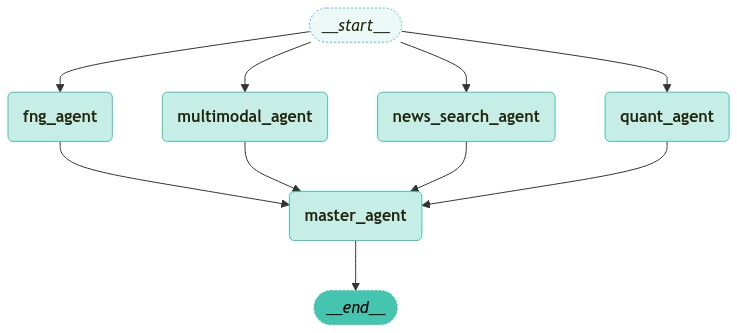

Page loaded
Element found
Menu button clicked
4-hour chart selected
Screenshot saved at: 1105_11_upbit_full_chart_4hour.png
Driver quit
Image path: 1105_11_upbit_full_chart_4hour.png



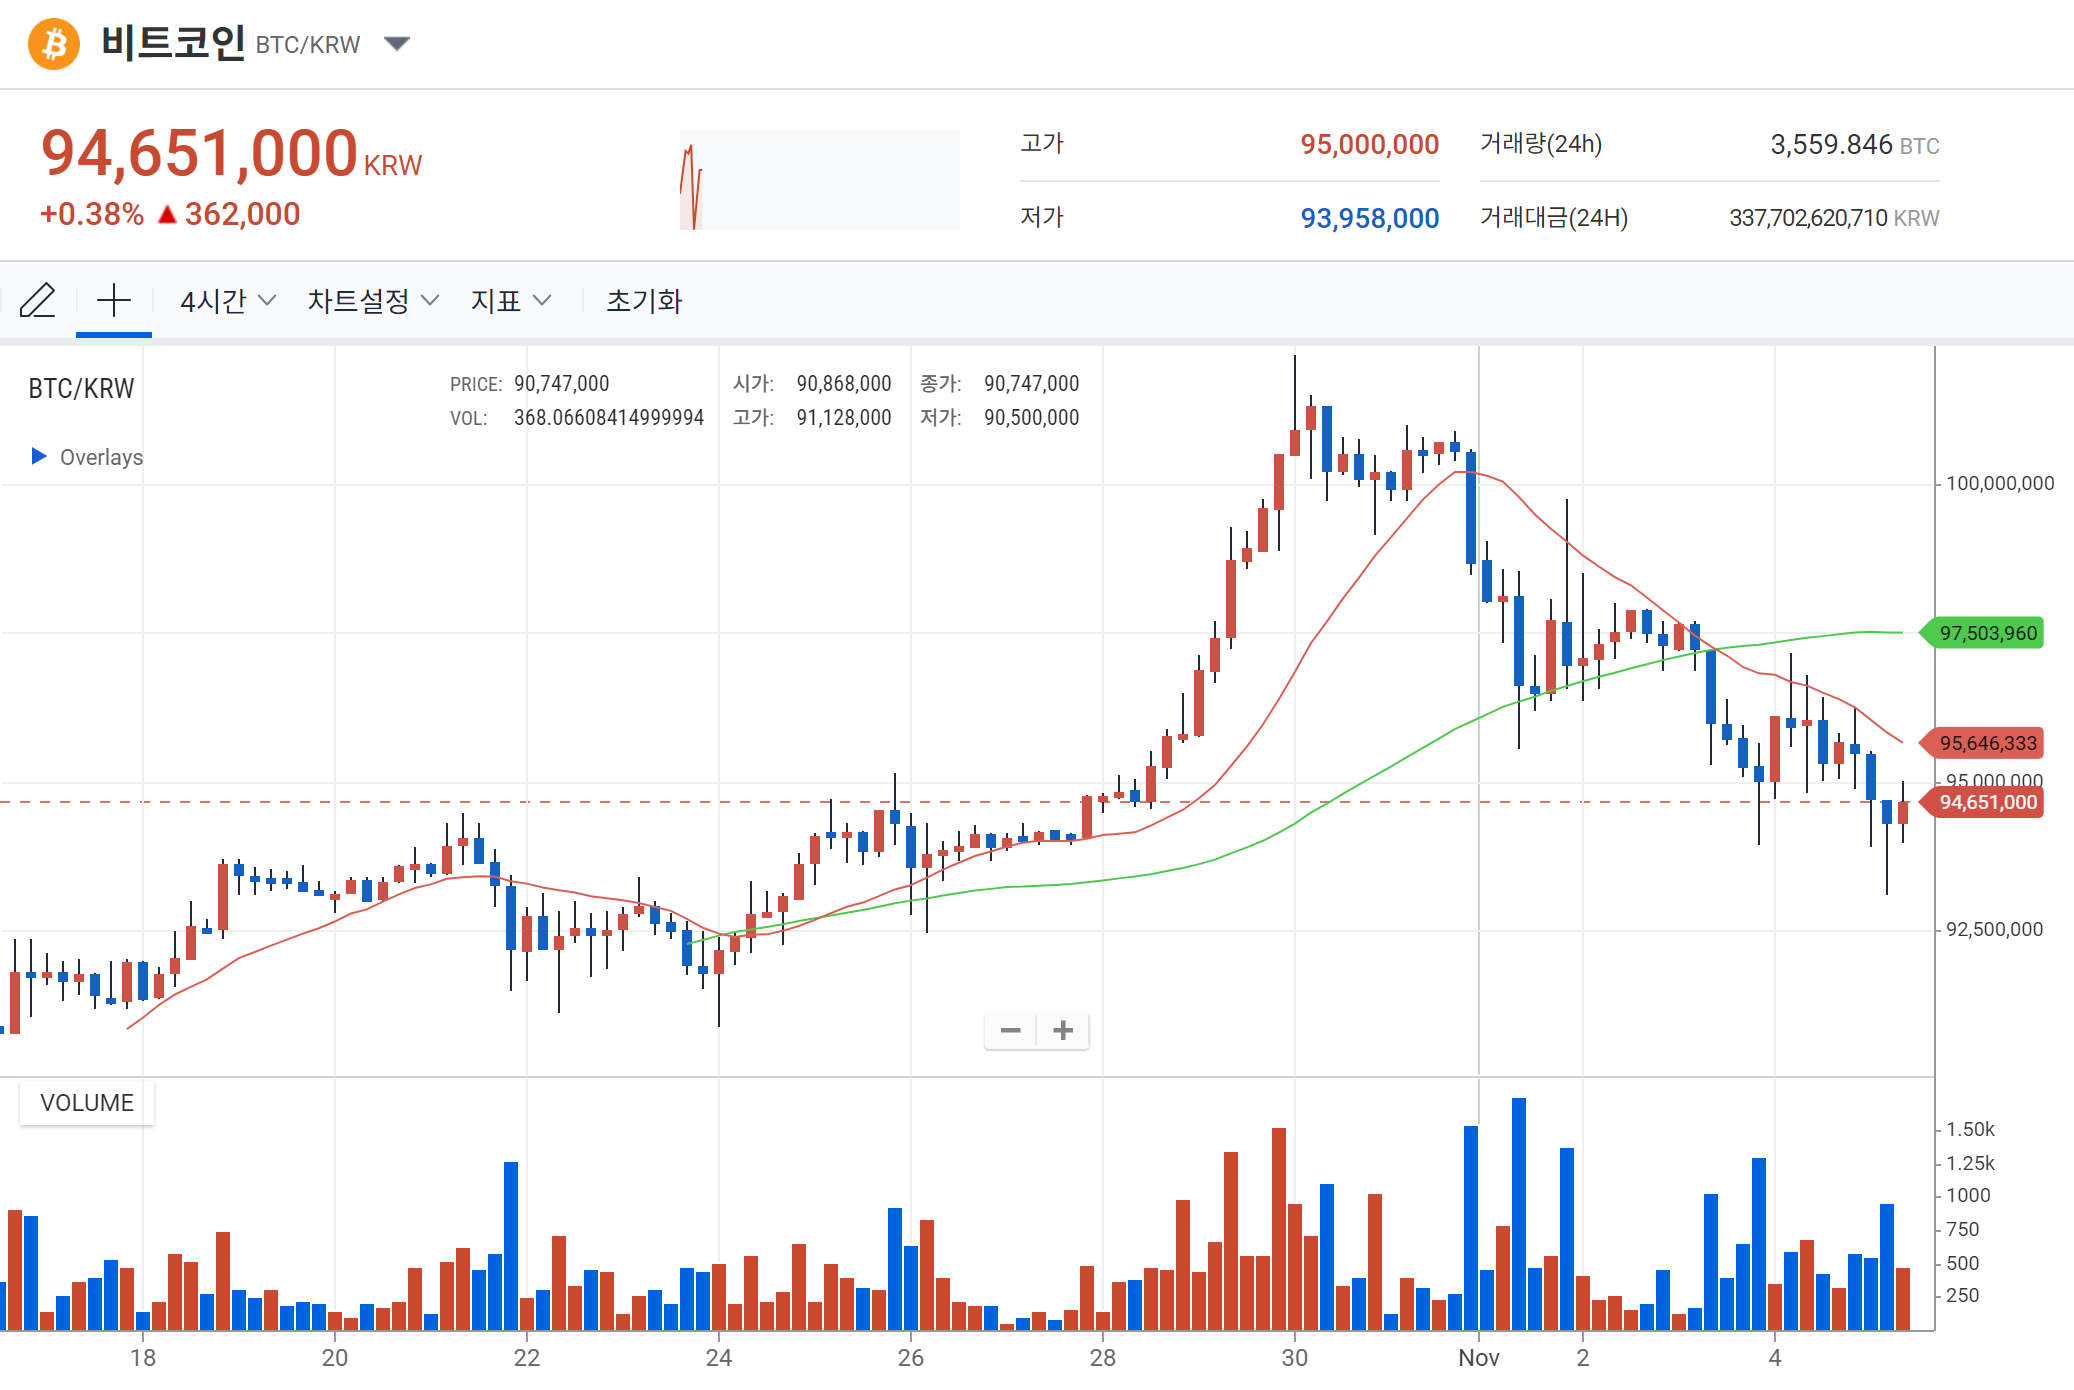

decision count: BUY(0), SELL(0), HOLD(4)
Master: HOLD


In [6]:
# 차트 이미지 분석 결과를 위한 Pydantic 모델
class ImageAnalysisResult(BaseModel):
    decision: Literal["BUY", "SELL", "HOLD"]
    summary: str


# 프롬프트 템플릿 설정
image_analysis_template = """당신은 비트코인 차트를 해석하는 시각적 패턴 분석 전문가입니다.
 당신의 임무는 주어진 차트 이미지를 기반으로 주요 시각적 패턴과 거래 심리를 분석하여 사용자가 매수, 매도, 보류 중 하나의 결정을 내릴 수 있도록 도움을 주는 것입니다.

 분석해야 할 항목은 다음과 같습니다:
 1. 주요 차트 패턴 식별:
    - 특정 추세의 전환을 예고할 수 있는 시각적 패턴을 탐지합니다. 예를 들어, 상승 또는 하락 추세 끝에서 나타나는 헤드 앤 숄더 및 역 헤드 앤 숄더, 상승 및 하락 반전 신호를 주는 이중 바닥/이중 천장, 지속형 패턴으로 사용되는 삼각형 패턴(상승, 하락, 대칭), 단기 조정 후 지속되는 깃발 패턴 등을 탐지하세요.
 2. 거래량 스파이크와 시장 심리 분석:
    - 특정 시점에서 거래량이 급증한 부분을 찾아내어 시장 참여자들의 심리적 변화를 평가하세요. 예를 들어, 급격한 거래량 증가는 새로운 추세의 시작을 의미하거나 큰 시장 참여자들이 포지션을 조정하는 신호일 수 있습니다.
 3. 캔들스틱 반전 패턴 탐지:
    - 반전 신호로 자주 사용되는 특정 캔들 패턴을 탐지하세요. 예를 들어, 핀바(Pin Bar)는 강한 매도/매수 반전을 나타내며, 엔골핑(Engulfing) 패턴은 강력한 추세 전환 신호로 해석될 수 있습니다. 이러한 패턴들은 특정 구간에서 매수/매도 압력의 변화를 보여줍니다.
 4. 추세의 시각적 흐름과 돌파 분석:
    - 차트의 시각적 흐름을 분석하여 현재 추세가 유지되는지, 또는 변환될 가능성이 있는지 확인하세요. 예를 들어, 추세선 돌파가 예상되는 구간이나 강한 저항선/지지선 근처의 움직임을 주의 깊게 관찰하여 추세 전환의 가능성을 평가하세요.

 분석 결과를 다음 JSON 형식으로 제공해주세요:
 {{
     "decision": "BUY 또는 SELL 또는 HOLD 중 하나로만 작성",
     "summary": "시장 분석 및 예측 내용을 상세히 서술. 투자 결정을 제안하고 해당 이유를 서술",
 }}
 """

image_prompt_template = PromptTemplate.from_template(image_analysis_template)
image_output_parser = JsonOutputParser(pydantic_object=ImageAnalysisResult)

# MultiModal 객체 생성
multimodal = MultiModal(
    model=llm,
    system_prompt=image_analysis_template,
    user_prompt="""당신에게 주어진 이미지는 비트코인의 실시간 자산 변동 그래프입니다. 주요 시각적 패턴, 거래량 스파이크, 캔들스틱 반전 패턴, 추세의 시각적 흐름을 분석하고, 향후 4시간 내의 가격 예측 및 이에 따른 투자 전략을 JSON 형식으로 제안하세요."""
)


def multimodal_agent(state: State) -> State:
    try:
        # 셀레니움을 통해 실시간 차트 캡처
        image_path = capture_chart_screenshot()
        print(f"Image path: {image_path}")
        
        # 멀티모달 분석 수행
        result = multimodal.invoke(image_path)
        
        # JSON 파싱 및 결과 처리
        parsed_result = image_output_parser.parse(result)
        if isinstance(parsed_result, dict):
            parsed_result = ImageAnalysisResult(**parsed_result)
        
        # 새로운 메시지 생성
        new_message = (f"Chart Analysis Decision: {parsed_result.decision}, "
                       f"Summary: {parsed_result.summary}")
        updated_messages = state.messages + [new_message]

        return state.copy(update={
            "messages": updated_messages,
            "chart": {
                "decision": parsed_result.decision,
                "summary": parsed_result.summary
            }
        })
    except Exception as e:
        print(f"Error in multimodal_agent_state: {e}")
        return state


# 마스터 에이전트
master_template = """당신은 비트코인 시장의 투자 분석 전문가입니다.
    현재 당신 회사에 속한 투자 전문가들은 비트코인 투자 결정을 다음과 같이 했습니다:
    {master_decision}
    당신은 해당 결정을 따르기로 했습니다.
    
    해당 결정을 뒷받침하는 투자 전문가들의 의견을 종합해주세요:
    {contents}
    
    만약, 투자전문가들의 의견이 "DRAW"라면 당신이 전반적인 내용을 종합하여 "BUY", "SELL", "HOLD" 중 하나를 골라주세요.
    해당 결정을 가지고 투자 자본을 얼만큼의 비중으로 진행할지 퍼센트도 결정해주세요.

    결과는 반드시 JSON 형식으로 출력하세요:
    {{
        "decision": "BUY 또는 SELL 또는 HOLD 중 하나로만 작성",
        "percentage": "현재 가지고 있는 자본 중 몇 퍼센트를 의사결정 할지 0부터 50까지 10 단위로 작성. 만약 HOLD면 0으로 설정",
        "summary": "투자 결정에 대한 이유를 자세히 서술",
    }}

    주의사항:
    - decision은 반드시 BUY 또는 SELL 또는 HOLD 중 하나여야 합니다
    """

master_prompt_template = PromptTemplate.from_template(master_template)

class MasterAnalysis(BaseModel):
    summary: str
    percentage: int
    decision: Literal["BUY", "SELL", "HOLD"]

master_output_parser = JsonOutputParser(pydantic_object=MasterAnalysis)
master_chain = master_prompt_template | llm | master_output_parser

def count_decision(decision: Optional[str]) -> tuple[int, int, int]:
    """
    단일 결정에 대해 BUY/SELL/HOLD 카운트를 반환합니다.
    각 결정은 하나의 값만 가질 수 있으므로 (1,0,0), (0,1,0), (0,0,1) 중 하나를 반환합니다.
    반환값 순서: (BUY, SELL, HOLD)
    """
    if not decision:
        return (0, 0, 0)
    
    if decision == "BUY":
        return (1, 0, 0)
    elif decision == "SELL":
        return (0, 1, 0)
    elif decision == "HOLD":
        return (0, 0, 1)
    return (0, 0, 0)  # 유효하지 않은 결정의 경우

def master_agent(state: State) -> State:
    total_buy = 0
    total_sell = 0
    total_hold = 0

    # 1. Fear & Greed 결정 카운트
    if state.fng and "decision" in state.fng:
        buy, sell, hold = count_decision(state.fng["decision"])
        total_buy += buy
        total_sell += sell
        total_hold += hold

    # 2. 뉴스 검색 결정 카운트
    if state.news_search and "decision" in state.news_search:
        buy, sell, hold = count_decision(state.news_search["decision"])
        total_buy += buy
        total_sell += sell
        total_hold += hold

    # 3. 퀀트 분석 결정 카운트
    if state.quant and "decision" in state.quant:
        buy, sell, hold = count_decision(state.quant["decision"])
        total_buy += buy
        total_sell += sell
        total_hold += hold

    # 4. 이미지 분석 결정 카운트
    if state.chart and "decision" in state.chart:
        buy, sell, hold = count_decision(state.chart["decision"])
        total_buy += buy
        total_sell += sell
        total_hold += hold

    # 투표 결과 결정 (BUY, SELL, HOLD 순서로 조건 체크)
    if total_buy > total_sell and total_buy > total_hold:
        master_decision = "BUY"
    elif total_sell > total_buy and total_sell > total_hold:
        master_decision = "SELL"
    elif total_hold > total_buy and total_hold > total_sell:
        master_decision = "HOLD"
    else:
        master_decision = "DRAW"

    print(f"decision count: BUY({total_buy}), SELL({total_sell}), HOLD({total_hold})")
    print(f"Master: {master_decision}")

    # 마스터 결정 진행
    result = master_chain.invoke({
        "master_decision": master_decision, 
        "contents": state.messages
    })

    return state.copy(update={"messages": state.messages,"master": {"decision": result["decision"], "percentage": result["percentage"], "summary": result["summary"]}})


# 병렬 방식
# 그래프 생성 및 노드 추가
graph_builder = StateGraph(State)

# 병렬 실행을 위해 각 노드를 START에서 바로 실행
graph_builder.add_node("fng_agent", fng_agent)
graph_builder.add_node("news_search_agent", news_search_agent)
graph_builder.add_node("quant_agent", quant_agent)
graph_builder.add_node("multimodal_agent", multimodal_agent)
graph_builder.add_node("master_agent", master_agent)

# START에서 두 노드를 동시에 실행하고 END로 연결
graph_builder.add_edge(START, "fng_agent")
graph_builder.add_edge(START, "news_search_agent")
graph_builder.add_edge(START, "quant_agent")
graph_builder.add_edge(START, "multimodal_agent")

graph_builder.add_edge("fng_agent", "master_agent")
graph_builder.add_edge("news_search_agent", "master_agent")
graph_builder.add_edge("quant_agent", "master_agent")
graph_builder.add_edge("multimodal_agent", "master_agent")
graph_builder.add_edge("master_agent", END)

# 그래프 컴파일
graph = graph_builder.compile()

# 결과 시각화
from langchain_teddynote.graphs import visualize_graph
visualize_graph(graph)

# 그래프 실행
# 초기 State 객체 생성 시 이미지 경로 추가
initial_state = State(messages=[("user", "각 에이전트 별로 서로 다른 메시지를 받아 분석하세요.")])
result_state = graph.invoke(initial_state)